## Nation-Wide Data Science Jobscape

In [1]:
import pandas as pd
import numpy as np
import sklearn
import re
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup
from splinter import Browser
import scrapy

In [2]:
# NLTK
import nltk
from nltk.tokenize import word_tokenize, PunktSentenceTokenizer
from nltk.tag import pos_tag

In [3]:
#Plotly
import plotly.express as px
import plotly.graph_objects as go

In [3]:
# base_url = f'https://www.onetonline.org/link/localjobs/15-2051.00?st={state}'

In [11]:
states = ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA',
            'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD',
            'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ',
            'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC',
            'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY']

### Test

In [4]:
AL = pd.read_html(f'https://www.onetonline.org/link/localjobs/15-2051.00?st={states[1]}')
AL[0].head(5)

,Posted,Title and Company,Location
0,"May 13, 2023",Data ScientistFord Motor Company,"Juneau, AK"
1,"May 25, 2023",Senior Data ScientistHumana,"Anchorage, AK"
2,"June 3, 2023",Senior Data ScientistPearson,"Juneau, AK"
3,"May 26, 2023","Data Scientist, Product AnalyticsMeta","Juneau, AK"
4,"May 19, 2023","Data Scientist, Product AnalyticsMeta","Juneau, AK"


In [5]:
TABLES = []
for i in states:
    table = pd.read_html(f'https://www.onetonline.org/link/localjobs/15-2051.00?st={i}')
    TABLES.append(table[0])
TABLES

[            Posted                                  Title and Company  \
 0     May 13, 2023                   Data ScientistFord Motor Company   
 1     May 18, 2023                           Data ScientistGuidehouse   
 2   April 22, 2023                             Data ScientistDeloitte   
 3     May 18, 2023  Data Scientist and Applied MathematicianBooz A...   
 4     May 25, 2023                        Senior Data ScientistHumana   
 5     May 25, 2023                        Senior Data ScientistHumana   
 6     May 25, 2023                        Senior Data ScientistHumana   
 7     June 1, 2023                      Lead NLP Data ScientistHumana   
 8     June 3, 2023                       Senior Data ScientistPearson   
 9     May 26, 2023              Data Scientist, Product AnalyticsMeta   
 10    May 19, 2023              Data Scientist, Product AnalyticsMeta   
 11   April 6, 2023                   Cleared Data ScientistGuidehouse   
 12   April 7, 2023                HR 

In [6]:
df = pd.DataFrame()
for table in TABLES:
    df = pd.concat([df, table], axis=0)
df

,Posted,Title and Company,Location
0,"May 13, 2023",Data ScientistFord Motor Company,"Montgomery, AL"
1,"May 18, 2023",Data ScientistGuidehouse,"Huntsville, AL"
2,"April 22, 2023",Data ScientistDeloitte,"Birmingham, AL"
3,"May 18, 2023",Data Scientist and Applied MathematicianBooz A...,"Huntsville, AL"
4,"May 25, 2023",Senior Data ScientistHumana,"Birmingham, AL"
...,...,...,...
24,"May 20, 2023","Senior Data Scientist, Predictive Analytics/Ar...","Cheyenne, WY"
25,"May 24, 2023","Director, Data Science - Fraud DetectionTravel...","Cheyenne, WY"
26,"May 20, 2023",Data Engineer I - Data ModelerTravelers Insura...,"Cheyenne, WY"
27,"April 19, 2023",Data Analytics SpecialistCadmus,"Cheyenne, WY"


In [7]:
# Split the field at the point where lowercase and uppercase letters meet
pattern = r'(?<=[a-z])(?=[A-Z])'
df[['Title', 'Company']] = df['Title and Company'].str.split(pattern, n=1, expand=True)

# Remove any leading/trailing whitespaces
df['Title'] = df['Title'].str.strip()
df['Company'] = df['Company'].str.strip()

# Drop the 'Title and Company' Field
df.drop('Title and Company', axis=1, inplace=True)

# Split the Location field at the comma to create a City and State field
df[['City', 'State']] = df['Location'].str.split(',', n=1, expand=True)

# Remove any leading/trailing whitespace on the State and City fields values
df['State'] = df['State'].str.strip()
df['City'] = df['City'].str.strip()

# Do not drop the Location column in case of need for combined field while Mapping

# Reorder columns
df = df[['State', 'City', 'Title', 'Company', 'Posted', 'Location']]

# Inspect resulting df
df

,State,City,Title,Company,Posted,Location
0,AL,Montgomery,Data Scientist,Ford Motor Company,"May 13, 2023","Montgomery, AL"
1,AL,Huntsville,Data Scientist,Guidehouse,"May 18, 2023","Huntsville, AL"
2,AL,Birmingham,Data Scientist,Deloitte,"April 22, 2023","Birmingham, AL"
3,AL,Huntsville,Data Scientist and Applied Mathematician,Booz Allen Hamilton,"May 18, 2023","Huntsville, AL"
4,AL,Birmingham,Senior Data Scientist,Humana,"May 25, 2023","Birmingham, AL"
...,...,...,...,...,...,...
24,WY,Cheyenne,"Senior Data Scientist, Predictive Analytics/Ar...",None,"May 20, 2023","Cheyenne, WY"
25,WY,Cheyenne,"Director, Data Science - Fraud Detection",Travelers Insurance Company,"May 24, 2023","Cheyenne, WY"
26,WY,Cheyenne,Data Engineer I - Data Modeler,Travelers Insurance Company,"May 20, 2023","Cheyenne, WY"
27,WY,Cheyenne,Data Analytics Specialist,Cadmus,"April 19, 2023","Cheyenne, WY"


In [16]:
df.to_csv('us_ds_jobs.csv', index=False)

### Read in CSV

In [4]:
df = pd.read_csv('us_ds_jobs.csv')
df

,State,City,Title,Company,Posted,Location
0,AL,Montgomery,Data Scientist,Ford Motor Company,"May 13, 2023","Montgomery, AL"
1,AL,Huntsville,Data Scientist,Guidehouse,"May 18, 2023","Huntsville, AL"
2,AL,Birmingham,Data Scientist,Deloitte,"April 22, 2023","Birmingham, AL"
3,AL,Huntsville,Data Scientist and Applied Mathematician,Booz Allen Hamilton,"May 18, 2023","Huntsville, AL"
4,AL,Birmingham,Senior Data Scientist,Humana,"May 25, 2023","Birmingham, AL"
...,...,...,...,...,...,...
2490,WY,Cheyenne,"Senior Data Scientist, Predictive Analytics/Ar...",NaN,"May 20, 2023","Cheyenne, WY"
2491,WY,Cheyenne,"Director, Data Science - Fraud Detection",Travelers Insurance Company,"May 24, 2023","Cheyenne, WY"
2492,WY,Cheyenne,Data Engineer I - Data Modeler,Travelers Insurance Company,"May 20, 2023","Cheyenne, WY"
2493,WY,Cheyenne,Data Analytics Specialist,Cadmus,"April 19, 2023","Cheyenne, WY"


### Inspect Titles

In [5]:
title_vc = df['Title'].value_counts()
title_vc

Data Scientist                                      266
Senior Data Scientist                               249
Data Scientist, Product Analytics                   169
Data Scientist, Product Analytics - Monetization    150
Data Scientist, Product - Generative AIMeta          76
                                                   ... 
Imaging Data Scientist                                1
Data Scientist IICorteva Agriscience                  1
Senior Director–BI&A AI/ML Data Science               1
Senior Data Scientist - Procurement                   1
Senior Scientist - Mycoplasma                         1
Name: Title, Length: 418, dtype: int64

In [6]:
# Define job_titles
job_titles = df['Title']

In [7]:
# Get unique titles
unique_titles = job_titles.unique()
print(f'There are {len(unique_titles)} unique Data Science-Related Job Titles currently posted in the U.S. on O*NET OnLine.')
unique_titles[0:5]

There are 418 unique Data Science-Related Job Titles currently posted in the U.S. on O*NET OnLine.


array(['Data Scientist', 'Data Scientist and Applied Mathematician',
       'Senior Data Scientist', 'Lead NLP Data Scientist',
       'Data Scientist, Product Analytics'], dtype=object)

### Parse Job Titles with NLTK

In [8]:
def parse_job_titles(job_titles):
    # Load the Punkt tokenizer for sentence tokenization
    sentence_tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

    # Tokenize each job title and perform part-of-speech tagging
    parsed_titles = []
    for title in job_titles:
        sentences = sentence_tokenizer.tokenize(title)
        for sentence in sentences:
            words = word_tokenize(sentence)
            tagged_words = pos_tag(words)
            parsed_titles.append(tagged_words)

    return parsed_titles

In [9]:
# Parse the job titles
parsed_job_titles = parse_job_titles(job_titles)

In [10]:
parsed_job_titles[0]

[('Data', 'NNS'), ('Scientist', 'NN')]

In [11]:
from nltk.probability import FreqDist

# Extract job categories from parsed titles
job_categories = []
for parsed_title in parsed_job_titles:
    for word, tag in parsed_title:
        if tag == 'NN' or tag.startswith('NNS'):
            job_categories.append(word.lower())

# Create frequency distribution of job categories
freq_dist = FreqDist(job_categories)

# Print the most common job categories
most_common_categories = freq_dist.most_common(10)
for category, count in most_common_categories:
    print(f"{category}: {count} occurrences")

scientist: 692 occurrences
data: 484 occurrences
monetization: 150 occurrences
aimeta: 76 occurrences
analytics: 73 occurrences
companies: 55 occurrences
business: 50 occurrences
specialist: 48 occurrences
detection: 46 occurrences
intelligence: 9 occurrences


### Parse job titles for each State in DataFrame

In [12]:
# Create an empty dictionary to store the frequency distributions
state_freq_dists = {}

# Iterate over unique states in the DataFrame
for state in df['State'].unique():
    # Filter job titles for the current state
    job_titles_state = df.loc[df['State'] == state, 'Title']

    # Parse the job titles for the current state
    parsed_job_titles_state = parse_job_titles(job_titles_state)

    # Extract job categories from parsed titles
    job_categories_state = []
    for parsed_title in parsed_job_titles_state:
        for word, tag in parsed_title:
            if tag == 'NN' or tag.startswith('NNS'):
                job_categories_state.append(word.lower())

    # Create frequency distribution for the current state
    freq_dist_state = FreqDist(job_categories_state)

    # Store the frequency distribution in the dictionary
    state_freq_dists[state] = freq_dist_state

# Print the frequency distributions for each state
for state, freq_dist in state_freq_dists.items():
    print(f"State: {state}")
    print(freq_dist.most_common(5))  # Print most common categories for each state
    print()

State: AL
[('scientist', 10), ('data', 5), ('monetization', 2), ('aimeta', 1), ('companies', 1)]

State: AK
[('scientist', 4), ('data', 2), ('monetization', 2), ('aimeta', 1), ('companies', 1)]

State: AZ
[('scientist', 11), ('data', 10), ('analytics', 3), ('product', 2), ('monetization', 2)]

State: AR
[('scientist', 10), ('data', 7), ('monetization', 2), ('aimeta', 1), ('req001119_43245530923_1-3175the', 1)]

State: CA
[('scientist', 33), ('data', 22), ('monetization', 4), ('companies', 4), ('years', 3)]

State: MD
[('scientist', 34), ('data', 26), ('care', 2), ('monetization', 2), ('aimeta', 1)]

State: CO
[('scientist', 19), ('data', 12), ('pricing', 2), ('senior', 2), ('monetization', 2)]

State: CT
[('scientist', 9), ('data', 6), ('monetization', 2), ('aimeta', 1), ('companies', 1)]

State: nan
[]

State: DE
[('scientist', 7), ('data', 3), ('monetization', 2), ('phiexelon', 1), ('aimeta', 1)]

State: FL
[('scientist', 29), ('data', 24), ('monetization', 2), ('citigroup', 2), ('re

In [13]:
# Convert frequency distributions to a DataFrame
df_freq_dists = pd.DataFrame(state_freq_dists).fillna(0).astype(int)

df_freq_dists

,AL,AK,AZ,AR,CA,MD,CO,CT,NaN,DE,...,TX,UT,VT,VA,WV,WA,DC,D.C.,WI,WY
data,5,2,10,7,22,26,12,6,0,3,...,27,3,4,39,5,12,12,0,7,2
scientist,10,4,11,10,33,34,19,9,0,7,...,30,10,5,54,18,22,15,0,11,5
aimeta,1,1,1,1,2,1,1,1,0,1,...,2,2,2,0,2,3,1,0,2,2
monetization,2,2,2,2,4,2,2,2,0,2,...,4,4,4,0,4,6,2,0,4,4
companies,1,1,1,1,4,1,1,1,0,1,...,1,1,1,0,1,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
customer,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
obsession,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
analysts,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
e,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [14]:
# Drop 'data' and 'scientist' for more meaningful analysis
df_freq_dists_drop_ds = df_freq_dists.drop(df_freq_dists.index[:2])
df_freq_dists_drop_ds

,AL,AK,AZ,AR,CA,MD,CO,CT,NaN,DE,...,TX,UT,VT,VA,WV,WA,DC,D.C.,WI,WY
aimeta,1,1,1,1,2,1,1,1,0,1,...,2,2,2,0,2,3,1,0,2,2
monetization,2,2,2,2,4,2,2,2,0,2,...,4,4,4,0,4,6,2,0,4,4
companies,1,1,1,1,4,1,1,1,0,1,...,1,1,1,0,1,0,0,0,1,1
business,1,0,1,1,1,1,1,1,0,1,...,1,1,1,0,1,0,0,0,1,0
detection,1,1,1,1,0,1,0,1,0,1,...,1,1,1,0,1,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
customer,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
obsession,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
analysts,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
e,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [15]:
top_ten = df_freq_dists_drop_ds.iloc[0:9,:]
top_ten

,AL,AK,AZ,AR,CA,MD,CO,CT,NaN,DE,...,TX,UT,VT,VA,WV,WA,DC,D.C.,WI,WY
aimeta,1,1,1,1,2,1,1,1,0,1,...,2,2,2,0,2,3,1,0,2,2
monetization,2,2,2,2,4,2,2,2,0,2,...,4,4,4,0,4,6,2,0,4,4
companies,1,1,1,1,4,1,1,1,0,1,...,1,1,1,0,1,0,0,0,1,1
business,1,0,1,1,1,1,1,1,0,1,...,1,1,1,0,1,0,0,0,1,0
detection,1,1,1,1,0,1,0,1,0,1,...,1,1,1,0,1,0,0,0,1,1
analytics,1,0,3,1,2,1,2,1,0,1,...,3,2,1,0,1,0,0,0,2,1
specialist,1,0,1,1,0,1,1,1,0,1,...,1,1,1,0,1,0,0,0,1,1
product,0,0,2,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
marketing,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


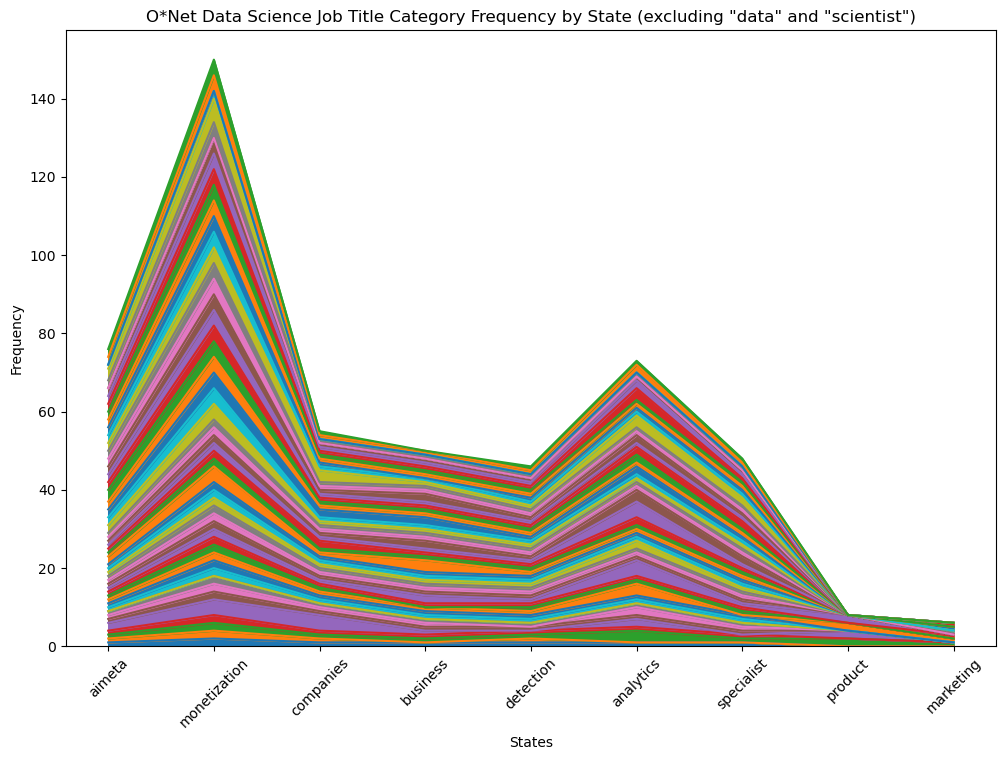

In [18]:
# Stacked Area Plot
top_ten.plot(kind='area', stacked=True, legend=False, figsize=[12,8])
plt.xlabel('States')
plt.ylabel('Frequency')
plt.title('O*Net Data Science Job Title Category Frequency by State (excluding "data" and "scientist")')

# Rotate x-axis tick labels by 45 degrees
plt.xticks(rotation=45)
plt.savefig('ds_job_title_category_area_plot.png')
plt.show()

### Note for future work: Go back and remove 'Data' and 'Scientist' from all the job titles that don't only contain 'Data Scientist', then run the script again.